# Nov2 ejercicio de clase

##### Encuentra los valores de pendiente y ordenada al origen para el archivo test_line.npy que se encuentra en la carpeta de datos:
###### 1. Usa la minimización de chisq.
###### 2. Usa tu código de mcmc.
###### 3. Compara los resultados, con los valores verdaderos (dados en clase)
###### 4. Usa emcee para volver a hacer el proceso de inferencia, y compara con los resultados anteriores.

In [34]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import distributions
from getdist import plots, gaussian_mixtures
from getdist import plots, MCSamples

In [35]:
data=np.load('test_line.npy')
#data=np.load('fit_exercise.npy')

### 1. Minimización de chisq desarrollado durante el curso

###### usaremos los programas anteriormenete desarrollados.

In [36]:
X=data[0,]
Y=data[1,]
Sigma=data[2,]
Sigma_sqrt=Sigma
Sigma_sq=Sigma**2   

S=[np.sum(Y/Sigma_sq),np.sum((Y*X)/Sigma_sq)]
M=[(np.sum(1/Sigma_sq),np.sum(X/Sigma_sq)),(np.sum(X/Sigma_sq),np.sum((X**2)/Sigma_sq))]
M_inv = np.linalg.inv(M)
solucion=M_inv @ S
y=np.zeros(len(X))

#usando los valores de X tenemos
for i in range (len(X)):
    y[i]=solucion[0]+solucion[1]*X[i]


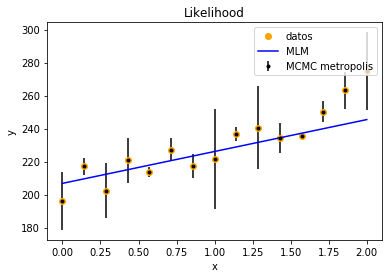

Pendiente= 19.33866347930484 Ordenada= 206.78479937537327


In [37]:
plt.plot(data[0],data[1], 'o', color='orange')
plt.plot(X,y, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(data[0],data[1],data[2], fmt='.k')
plt.title('Likelihood')
plt.legend(('datos','MLM', 'MCMC metropolis'), loc='upper right')
plt.show()
print('Pendiente=', solucion[1],'Ordenada=', solucion[0])

### 2. Usando MCMC desarrollado durante el curso

In [38]:
#condicioenes para el prior
a_min, a_max=-10, 10
b_min, b_max=-10, 10

def prior(a, b, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max):
    logp=0
    if a>a_min and a<a_max and b>b_min and b<b_max:
        logp=np.log(1/(a_max-a_min)+1/(b_max-b_min))
    return logp

def Likelihood(a, b, t=data[2], y=data[1], x=data[0]):
    log_like=0
    mu = a + b*x
    log_like += -0.5*np.sum(np.log(2*np.pi*t**2)+(y - mu)**2/(t**2))
    return log_like

def calc_posterior(a, b, t=data[2], y=data[1], x=data[0]): 
    log_posterior=0
    log_posterior = Likelihood(a,b)
    return log_posterior

In [39]:
def metropolis(n_iterations, initial_values, prop_var):
             
    evolution = np.zeros((n_iterations+1, len(initial_values)))  #en esta matriz se guardará los parametros a, b y sigma
    evolution_R= np.zeros((n_iterations+1, len(initial_values))) #se gurdarán todos los valores rechazados y aceptados
    evolution[0] = initial_values     
    evolution_R[0] = initial_values
    current_log_prob = calc_posterior(*evolution[0])  #llamado a la función con entradas como vector de los parametros
    accepted = [0]*len(initial_values)                #contador de cuantas veces se rechazó o se guardó el parametro

    for i in range(n_iterations):      
        current_params = evolution[i]   #paramatros iniciales para los valores que se calcularan 
        for j in range(len(initial_values)):        
            p = evolution[i].copy()     #Realiza una copia de la fila i-esima para calcular nuevamente el postirior y comparar
            theta = np.random.normal (current_params[j], prop_var)    #se crean los numeros aleatorios de a, b y sigma    
            p[j] = theta                             #p contiene los parametros con los que se calculara el nuevo posterior
            proposed_log_prob = calc_posterior(*p)   #se calcula el postitior con los valores de p propuestos
            alpha = proposed_log_prob - current_log_prob #se calcula el ratio de los postiriors (nuevo - viejo)
            
            if np.log(np.random.rand()) < alpha:  
                evolution[i+1,j] = theta
                current_log_prob = proposed_log_prob    #se acepta el nuevo prior y se guarda
                accepted[j] += 1                        #contador de veces aceptado
            else:                      
                evolution[i+1,j] = evolution[i,j]
            
            evolution_R[i+1,j] = p[j]                   #se guardan todos los valores para graficar
                
    return evolution, evolution_R, accepted

In [94]:
n_iterations=10000
prop_des=1
walkers=2
alpha=-100
beta=100

initial_values=[np.random.uniform(alpha, beta),np.random.uniform(alpha,beta)]
E_W=np.zeros((walkers,n_iterations+1,len(initial_values)))      #evolution walker acepted
E_W_R=np.zeros((walkers,n_iterations+1,len(initial_values)))    #evolution walker reject


for l in range (0,walkers):
    initial_values=[np.random.uniform(alpha, beta),np.random.uniform(alpha,beta)]
    evolution = metropolis(n_iterations,initial_values,prop_des)        
    E_W[l]=evolution[0]      #guarda los valores aceptados de la evolución de cada uno de los llamados a la función metropolis
    E_W_R[l]=evolution[1]    #guarda los todos los valores aceptados y rechazados para graficar al fondo

    
iteration= np.arange(len(E_W[l,:,0]))

solution for walker number 0
[209.2427648   18.75791707]
mean a= 203.28308078572988 
mean b= 20.725473357793458
std a= 20.020564481495807 
std b= 8.531937878070295
    
solution for walker number 1
[204.33398724  19.45613483]
mean a= 200.96759725099076 
mean b= 20.03680880153584
std a= 27.86023387680459 
std b= 7.678517418940364
    


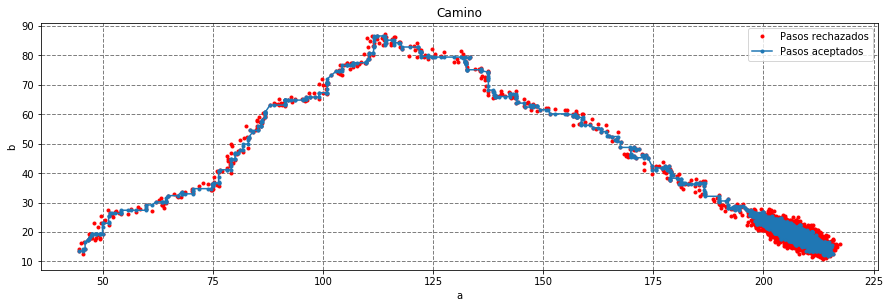

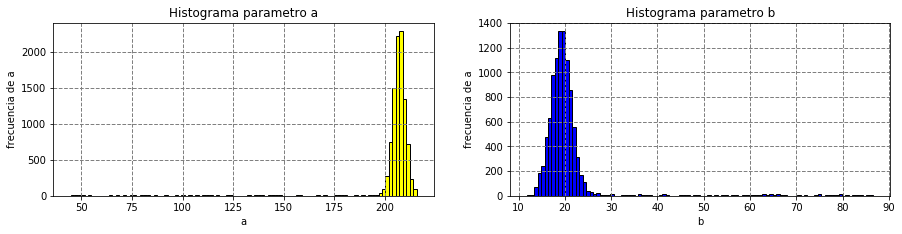

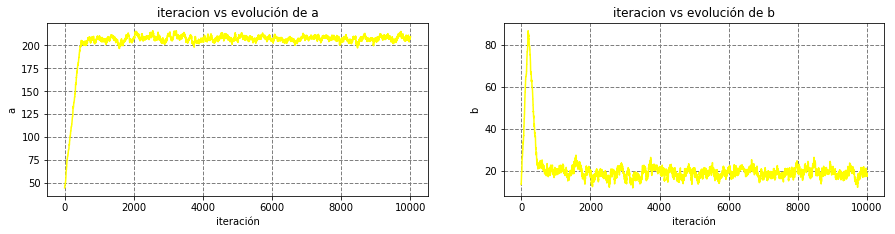

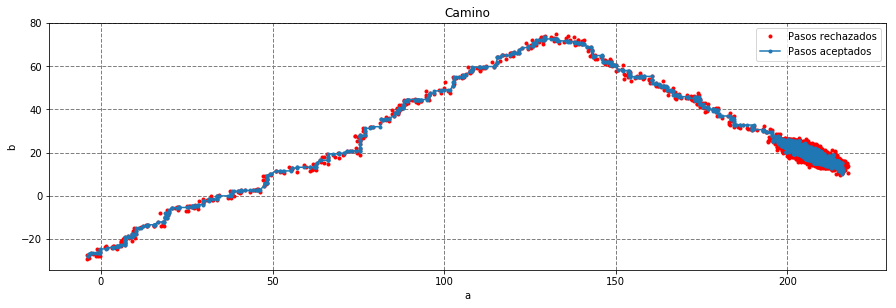

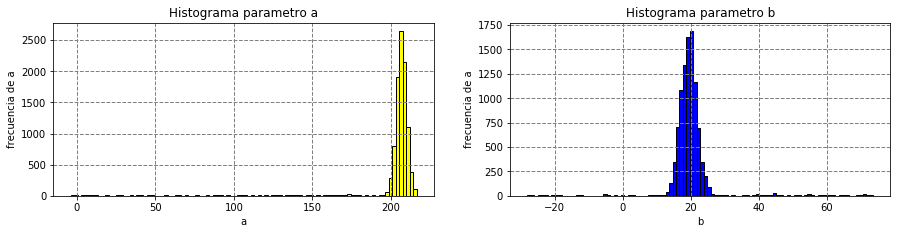

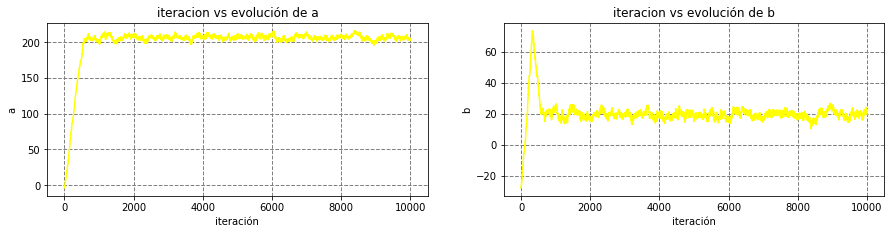

In [95]:
#caminos
for ll in range (walkers):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,2)
    plt.plot(E_W_R[ll,:,0],E_W_R[ll,:,1],'.', color='red')
    plt.plot(E_W[ll,:,0],E_W[ll,:,1],'.-')
    plt.title("Camino")
    plt.xlabel("a")              
    plt.ylabel("b") 
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    plt.legend(('Pasos rechazados', 'Pasos aceptados'), loc='upper right')
    print('solution for walker number', ll )
    print(E_W[ll,-1,:])
    print('mean a=', np.mean(E_W[ll,:,0]),'\n' 'mean b=', np.mean(E_W[ll,:,1]))
    print('std a=', np.std(E_W[ll,:,0]),'\n' 'std b=', np.std(E_W[ll,:,1]))
    print('    ')

#histogramas    
    plt.figure(figsize=(15,7))
    plt.subplot(2,2,1)
    plt.hist(E_W[ll,:,0],100,color='yellow',edgecolor='black',label='parametro b');
    plt.title("Histograma parametro a")
    plt.xlabel('a')              
    plt.ylabel('frecuencia de a')               
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

    plt.subplot(2,2,2)
    plt.hist(E_W[ll,:,1],100,color='blue',edgecolor='black',label='parametro a');
    plt.title("Histograma parametro b")
    plt.xlabel("b")              
    plt.ylabel("frecuencia de a") 
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)
    
#cambios de parametros en las iteraciones
    plt.figure(figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(iteration,E_W[ll,:,0],color='yellow',label='parametro b');
    plt.title("iteracion vs evolución de a")
    plt.xlabel('iteración')              
    plt.ylabel('a')               
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

    plt.subplot(2,2,2)
    plt.plot(iteration,E_W[ll,:,1],color='yellow',label='parametro a');
    plt.title("iteracion vs evolución de b")
    plt.xlabel('iteración')              
    plt.ylabel('b')   
    #plt.ylim(np.min(E_W[ll,:,1]),np.max(E_W[ll,:,1]))
    plt.grid(color = '0.5', linestyle = '--', linewidth = 1)

In [96]:
def Gelman_Rubin(chain):
    mean_for_chain=(np.zeros(walkers))
    si_sqrt=np.zeros(walkers)
    S=np.zeros(walkers)
    parameter_mean=np.zeros(walkers)
    B_n=0
    for w in range (walkers):
        si_sqrt[w]=1/(n_iterations-1)*(np.sum((chain[w,:])-np.mean(chain[w,:])**2))
        parameter_mean[w]=np.mean(chain[w,:])
        
    S_sqrt=1/walkers*(np.sum(si_sqrt))
    overal_mean=np.mean(parameter_mean)
    B_n=1/(walkers-1)*np.sum((parameter_mean-overal_mean)**2)
    sigma=(n_iterations-1)/n_iterations*S_sqrt+B_n
    R=np.sqrt(sigma/S_sqrt)

    return R
   

In [97]:
R_a=Gelman_Rubin(E_W[:,:,0])
R_b=Gelman_Rubin(E_W[:,:,1])
print('R for a and b')
print(R_a, R_b)

acepted_parameter=evolution[2]
acepted_point=np.min(acepted_parameter)
Acepted_percent=acepted_point/n_iterations*100
print(Acepted_percent, '%')


R for a and b
0.9999170329552782 0.9996499323826087
61.86000000000001 %


### 3. Compara los resultados, con los valores verdaderos (dados en clase)

###### Los resultados dados en clase son pendiente de 30 y ordenada 200, claramente son diferentes de los obtenidos con el MCMC Metropolis creado por mi, igualmenete los compañeros de clase no obtienen resultados similares, en realidad lo que pasa es que los errores estan siendo tomados en cuenta, esto hace que los resultados difieran ya que estamos considerando una maximización del Likelihood el cual arroja talvez no la sulución mas aproximada de los puntos a la recta a los que los estamos aproximando pero de acuerdo con un experimento real y datos medidios reales (parametros y error) arroja los valores mas probales de acuerdo con los valores reportados

In [98]:
#graficando los datos con la solución obtenida
ysol=np.zeros(len(data[0]))
y_real=np.zeros(len(data[0]))
for i in range (len(data[0])):
    ysol[i]=E_W[ll,-1,0]+E_W[ll,-1,1]*data[0,i]
    y_real[i]=200+30*data[0,i]

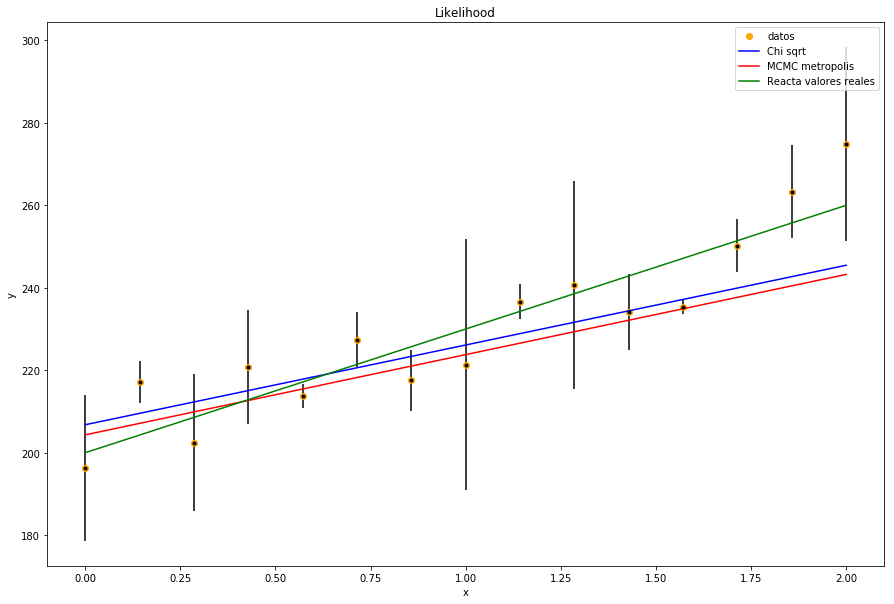

In [101]:
plt.figure(figsize=(15,10))
plt.plot(data[0],data[1], 'o', color='orange')
plt.plot(X,y, color='blue')
plt.plot(data[0],ysol, color='red')
plt.plot(data[0],y_real, color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(data[0],data[1],data[2], fmt='.k')
plt.title('Likelihood')
plt.legend(('datos','Chi sqrt', 'MCMC metropolis', 'Reacta valores reales'), loc='upper right')
plt.show()

### 4. Usa emcee para volver a hacer el proceso de inferencia, y compara con los resultados anteriores.

In [103]:
import emcee 

###### usando nuevamente nuestras funciones que calculan el posterior para usarlas en el MCMC de emcee

In [185]:
#condicioenes para el prior
a_min, a_max=-10, 10
b_min, b_max=-10, 10

def prior(theta, a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max):
    b, a, = theta
    logp=0
    if a>a_min and a<a_max and b>b_min and b<b_max:
        logp=np.log(1/(a_max-a_min)+1/(b_max-b_min))
    return logp

def Likelihood(theta, X,Y,Sigma):
    b, a = theta #parámetros
    log_like=0
    mu = b + a*X
    log_like += -0.5*np.sum(np.log(2*np.pi*Sigma**2)+(y - mu)**2/(Sigma**2))
    return log_like

def calc_posterior(theta, X,Y,Sigma): 
    log_posterior=0
    log_posterior = Likelihood(theta,X,Y,Sigma)
    return log_posterior

###### adaptando el ejemplo que esta en la librería emcee 

In [189]:
nwalkers=20 #número de walkers
ndim=2 #número de dimensiones (parámetros)
pos=np.random.uniform(-10,10, size=(nwalkers, ndim)) #generador de valores guess
#***Usando emcee***
n_iterations=1000
sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_posterior, args=(X,Y,Sigma))
sampler.run_mcmc(pos,n_iterations, progress=True);

100%|██████████| 1000/1000 [00:02<00:00, 370.04it/s]


#### Grafico de iteración-parametro

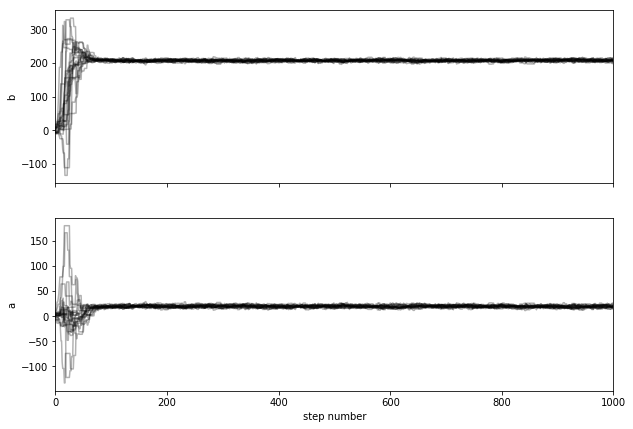

In [190]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "a"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

#### Grafico del triangulo

Removed no burn in


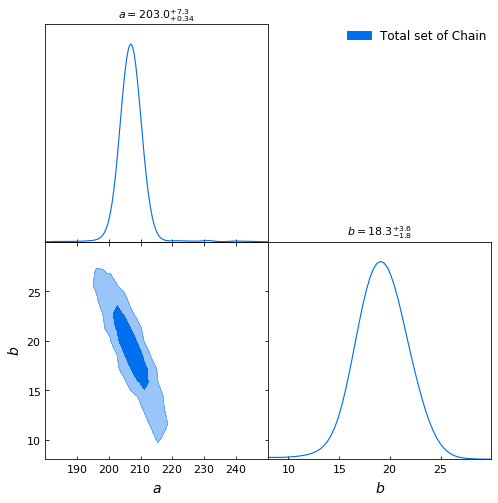

In [212]:
c_a=0
c_b=0
for z in range(0,nwalkers):        #en este for juntamos todas las cadenas para hacer la grafica del triangulo con una sola 
                                  #cadena que corresponde a unir todas las cadenas
    c_a=np.append(c_a,samples[:,z,0])
    c_b=np.append(c_b,samples[:,z,1])
    
SampsP=np.array([c_a.T,c_b.T]).T
names = ['a0', 'b0']
labels =  ['a', 'b']
SamplesP = MCSamples(samples=SampsP,names = names, labels = labels, label='Second set')

g = plots.get_subplot_plotter(4)
g.settings.figure_legend_frame = False
g.triangle_plot([SamplesP], filled=True, 
                legend_labels = ['Total set of Chain'], legend_loc='upper right',
                title_limit=1, param_limits={'a0': (180, 250), 'b0': (8, 30)}, markers={'a':0})

# cambiando title_limit a 2 da un intervalo de confianza de 95%, siendo el 1 por defaut el de 68%
#el intervalo de confianza se muestra en la grafica del triangulo

